In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

In [44]:
# Vérifier si un GPU est disponible pour accélérer les calculs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

Entraînement sur : cuda:0


In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [46]:
# Transformation des données pour normaliser les pixels entre [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [47]:
# Charger les données d'entraînement et de test
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Batch de 64 échantillons

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [48]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Optimizer with regularization

In [49]:
# Liste pour stocker l'évolution de la perte
train_loss_history = []

# Mesurer le temps d'entraînement
start_time = time.time()

# Entraîner le modèle
for epoch in range(5):  # Nombre d'époques
    running_loss = 0.0  # Pour calculer la perte moyenne
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Forward Propagation
        outputs = model(inputs)
        # Calcul de la perte
        loss = criterion(outputs, labels)
         # Backward Propagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()

        # Ajouter la perte pour cette itération
        running_loss += loss.item()
        if i % 100 == 99:  # Afficher la perte toutes les 100 mini-batches
            train_loss_history.append(running_loss / 100)
            print('[%d, %5d] perte: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Temps total d'entraînement
end_time = time.time()
training_time = end_time - start_time
print(f"Entraînement terminé en {training_time:.2f} secondes")


[1,   100] perte: 0.683
[1,   200] perte: 0.176
[1,   300] perte: 0.115
[1,   400] perte: 0.105
[1,   500] perte: 0.078
[1,   600] perte: 0.074
[1,   700] perte: 0.080
[1,   800] perte: 0.064
[1,   900] perte: 0.061
[2,   100] perte: 0.049
[2,   200] perte: 0.054
[2,   300] perte: 0.049
[2,   400] perte: 0.043
[2,   500] perte: 0.051
[2,   600] perte: 0.044
[2,   700] perte: 0.038
[2,   800] perte: 0.039
[2,   900] perte: 0.045
[3,   100] perte: 0.037
[3,   200] perte: 0.038
[3,   300] perte: 0.030
[3,   400] perte: 0.029
[3,   500] perte: 0.028
[3,   600] perte: 0.022
[3,   700] perte: 0.032
[3,   800] perte: 0.031
[3,   900] perte: 0.030
[4,   100] perte: 0.018
[4,   200] perte: 0.024
[4,   300] perte: 0.019
[4,   400] perte: 0.032
[4,   500] perte: 0.028
[4,   600] perte: 0.027
[4,   700] perte: 0.020
[4,   800] perte: 0.031
[4,   900] perte: 0.031
[5,   100] perte: 0.013
[5,   200] perte: 0.015
[5,   300] perte: 0.015
[5,   400] perte: 0.013
[5,   500] perte: 0.020
[5,   600] perte

In [50]:
# Évaluer le modèle sur les données de test
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Prédire la classe avec la probabilité maximale
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Collecter les prédictions et labels réels pour les métriques
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

In [51]:
# Calcul de l'Accuracy
accuracy = 100 * correct / total
print(f'Exactitude du modèle sur 10,000 images de test: {accuracy:.2f}%')

# Calcul du score F1
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'Score F1 pour CNN: {f1:.4f}')

Exactitude du modèle sur 10,000 images de test: 98.88%
Score F1 pour CNN: 0.9888


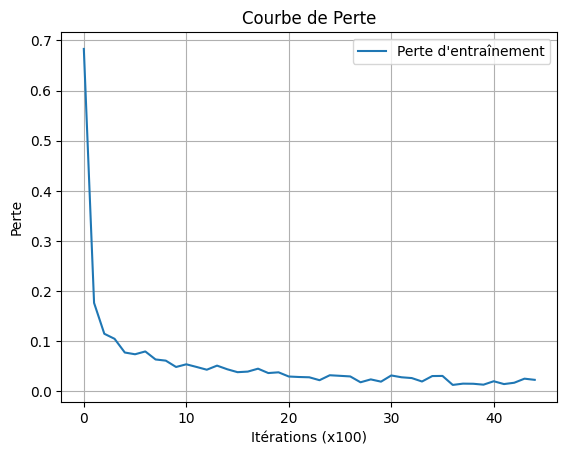

In [52]:
# Tracer la courbe de perte
plt.plot(train_loss_history, label='Perte d\'entraînement')
plt.title('Courbe de Perte')
plt.xlabel('Itérations (x100)')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Faster R-CNN
class FasterRCNN(nn.Module):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [81]:
 # Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

 # Charger les données MNIST
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))  # Normaliser
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [82]:
from torch.utils.data import random_split
# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [83]:
# Initialiser le model, loss function, and optimizer
model = FasterRCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [90]:
# Mesurer le temps d'entraînement
start_time = time.time()

train_loss_history = []
# Entraîner le modèle

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch : {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
# Temps total d'entraînement
end_time = time.time()
training_time = end_time - start_time
print(f"Entraînement terminé en {training_time:.2f} secondes")


Epoch : 1/10, Loss: 0.004674838996783099
Epoch : 2/10, Loss: 0.005003515144831321
Epoch : 3/10, Loss: 0.0031072330571195344
Epoch : 4/10, Loss: 0.003839544943840285
Epoch : 5/10, Loss: 0.003164490865272748
Epoch : 6/10, Loss: 0.0005556810601162916
Epoch : 7/10, Loss: 0.005004927337349834
Epoch : 8/10, Loss: 0.0053408753256506715
Epoch : 9/10, Loss: 0.0029207814165523632
Epoch : 10/10, Loss: 0.0007374835804433754
Entraînement terminé en 122.71 secondes


In [91]:
# Évaluer le modèle sur les données de test
correct = 0
total = 0
all_predictions=[]
all_labels=[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())
#Accuracy
frcnn_accuracy=100 * correct / total
print('Accuracy : %d %%' % frcnn_accuracy)

# F1 score
frcnn_f1 = f1_score(all_labels, all_predictions, average='weighted')
print("F1 Score:", frcnn_f1)

Accuracy : 99 %
F1 Score: 0.990206056818831
